# Model Comparison — Neural Networks (Boosting optional)

This notebook compares **your two neural-network variants** on the same labeled holdout set:

- Baseline MLP predictions: `results/nn_baseline_test_preds.csv`
- Improved MLP predictions: `results/nn_improved_test_preds.csv`

add boosting later:

- Boosting predictions: `results/boosting_best_test_preds.csv` (optional)

All prediction files must be generated on the same labeled holdout set (same `UNIQUEID`s).

**Expected columns in each prediction file:**

- `UNIQUEID`
- `y_true` (0/1)
- `y_prob` (predicted probability of default)

---

## How to include boosting later

1) Drop boosting models file at `results/boosting_best_test_preds.csv`
2) In the next cell, set `USE_BOOST = True`
3) Re-run the notebook to include boosting in the merge, metrics, and ROC plot

In [7]:
import os

import numpy as np

import pandas as pd

from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    )

import matplotlib.pyplot as plt

RESULTS_DIR = os.path.join('..', 'results')

# Neural network prediction files (exported from your NN notebook)
NN_BASELINE_PATH = os.path.join(RESULTS_DIR, 'nn_baseline_test_preds.csv')
NN_IMPROVED_PATH = os.path.join(RESULTS_DIR, 'nn_improved_test_preds.csv')

# Boosting prediction file (exported by your colleague)
BOOST_PATH = os.path.join(RESULTS_DIR, 'boosting_best_test_preds.csv')

# Flip this to True once your colleague adds the boosting file.
USE_BOOST = False

id_col = 'UNIQUEID'

In [8]:
nn_base = pd.read_csv(NN_BASELINE_PATH)
nn_improved = pd.read_csv(NN_IMPROVED_PATH)

required = {id_col, 'y_true', 'y_prob'}
assert required.issubset(nn_base.columns), f"Baseline NN file missing columns: {required - set(nn_base.columns)}"
assert required.issubset(nn_improved.columns), f"Improved NN file missing columns: {required - set(nn_improved.columns)}"

# ------------------------------------------------------------
# OPTIONAL: Boosting (enable later)
boost = None
if USE_BOOST:
    boost = pd.read_csv(BOOST_PATH)
    assert required.issubset(boost.columns), f"Boosting file missing columns: {required - set(boost.columns)}"

# ------------------------------------------------------------
# Merge on UNIQUEID + y_true to ensure we're comparing the *same* labeled rows.
if USE_BOOST:
    merged = (
        boost[[id_col, 'y_true', 'y_prob']]
        .rename(columns={'y_prob': 'y_prob_boost'})
        .merge(
            nn_base[[id_col, 'y_true', 'y_prob']].rename(columns={'y_prob': 'y_prob_baseline'}),
            on=[id_col, 'y_true'],
            how='inner',
        )
        .merge(
            nn_improved[[id_col, 'y_true', 'y_prob']].rename(columns={'y_prob': 'y_prob_improved'}),
            on=[id_col, 'y_true'],
            how='inner',
        )
    )
else:
    merged = (
        nn_base[[id_col, 'y_true', 'y_prob']]
        .rename(columns={'y_prob': 'y_prob_baseline'})
        .merge(
            nn_improved[[id_col, 'y_true', 'y_prob']].rename(columns={'y_prob': 'y_prob_improved'}),
            on=[id_col, 'y_true'],
            how='inner',
        )
    )

print('Baseline NN rows:', len(nn_base))
print('Improved NN rows:', len(nn_improved))
if USE_BOOST:
    print('Boost rows:', len(boost))
    print('Matched rows (all 3):', len(merged))
else:
    print('Matched rows (NN only):', len(merged))

display(merged.head())

Baseline NN rows: 34974
Improved NN rows: 34974
Matched rows (NN only): 34974


,UNIQUEID,y_true,y_prob_baseline,y_prob_improved
0,490213,0,0.687483,0.673230
1,492995,1,0.841740,0.827259
2,586411,0,0.558664,0.559846
3,519075,0,0.468006,0.486597
4,525983,0,0.290159,0.284628


In [9]:
y_true = merged['y_true'].astype(int).values

p_baseline = merged['y_prob_baseline'].astype(float).values
p_improved = merged['y_prob_improved'].astype(float).values

if USE_BOOST:
    p_boost = merged['y_prob_boost'].astype(float).values


def metrics_at_threshold(y: np.ndarray, p: np.ndarray, t: float = 0.5) -> dict:
    yhat = (p >= t).astype(int)
    return {
        'auc_roc': float(roc_auc_score(y, p)),
        f'precision@{t:.2f}': float(precision_score(y, yhat, zero_division=0)),
        f'recall@{t:.2f}': float(recall_score(y, yhat, zero_division=0)),
        f'f1@{t:.2f}': float(f1_score(y, yhat, zero_division=0)),
    }

t = 0.50

rows = {
    'Baseline MLP': metrics_at_threshold(y_true, p_baseline, t=t),
    'Improved MLP': metrics_at_threshold(y_true, p_improved, t=t),
}
if USE_BOOST:
    rows['Boosting'] = metrics_at_threshold(y_true, p_boost, t=t)

summary = pd.DataFrame(rows).T
summary

,auc_roc,precision@0.50,recall@0.50,f1@0.50
Baseline MLP,0.650593,0.290820,0.668862,0.405381
Improved MLP,0.648562,0.294045,0.626976,0.400336


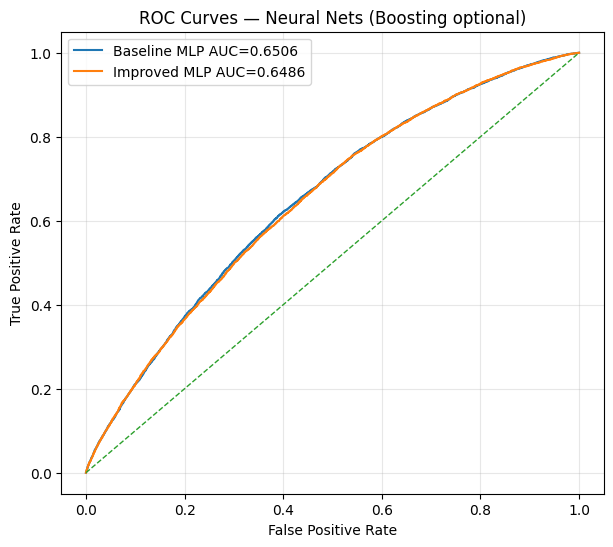

In [10]:
# ROC curves (NN by default; boosting optional)
fpr_base, tpr_base, _ = roc_curve(y_true, p_baseline)
fpr_impr, tpr_impr, _ = roc_curve(y_true, p_improved)

auc_base = roc_auc_score(y_true, p_baseline)
auc_impr = roc_auc_score(y_true, p_improved)

plt.figure(figsize=(7, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline MLP AUC={auc_base:.4f}')
plt.plot(fpr_impr, tpr_impr, label=f'Improved MLP AUC={auc_impr:.4f}')

if USE_BOOST:
    fpr_boost, tpr_boost, _ = roc_curve(y_true, p_boost)
    auc_boost = roc_auc_score(y_true, p_boost)
    plt.plot(fpr_boost, tpr_boost, label=f'Boosting AUC={auc_boost:.4f}')

plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Neural Nets (Boosting optional)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Notes

- By default this notebook compares **two NN models** only (`USE_BOOST = False`).
- When your colleague is ready, set `USE_BOOST = True` and ensure `results/boosting_best_test_preds.csv` exists.
- Metrics are computed at a **common threshold (0.50)** for an apples-to-apples comparison.
- If you want to compare using **per-model tuned thresholds** (e.g., tuned on validation), add that logic here, but keep it **validation-tuned** to avoid test leakage.